In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import yfinance as yf
from talib import abstract

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

# SK-learn libraries for data processing and learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

C:\ProgramData\Anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Get example data from Generated CSV File

In [2]:
# Get signal data written to csv to start
df = pd.read_csv("example_data.csv")
print(df.columns)
df.shape

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Return', 'Return%', 'L5D_Return', 'L5D_Return%',
       'N5D_Return', 'N5D_Return%', 'N5D_Return_Delayed',
       'N5D_Return_Delayed%', '52Wk_High', '52Wk_Low', '%52Wk_High',
       '%52Wk_Low', 'Open%PriorClose', 'Close%Open', 'Close%High', 'Close%Low',
       'Div%Close', '52Wk_Avg_Volume', '%52Wk_Avg_Volume', 'SMA3', 'SMA5',
       'SMA10', 'SMA15', 'SMA20', 'SMA30', 'SMA50', 'SMA3%', 'SMA5%', 'SMA10%',
       'SMA15%', 'SMA20%', 'SMA30%', 'SMA50%', 'EMA3', 'EMA5', 'EMA10',
       'EMA15', 'EMA20', 'EMA30', 'EMA50', 'EMA3%', 'EMA5%', 'EMA10%',
       'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%', 'PP', 'S1C', 'S2C', 'S3C',
       'R1C', 'R2C', 'R3C', 'PP%', 'S1C%', 'S2C%', 'S3C%', 'R1C%', 'R2C%',
       'R3C%', 'S1F', 'S2F', 'S3F', 'R1F', 'R2F', 'R3F', 'S1F%', 'S2F%',
       'S3F%', 'R1F%', 'R2F%', 'R3F%', 'SMA_Signal', 'MACD_Signal', 'RSI',
       'RSI_Signal', 'Slow_K', 'Slow_D', 'Stoch_Osci', 

(3771, 92)

In [3]:
# Adjusting Buy and Sell labels based on return, using the following metrics and thresholds
return_metric = df["N5D_Return_Delayed%"]
buy_threshold = 0.01
sell_threshold = -0.002

buy_signal = pd.Series(return_metric >= buy_threshold).astype(int)
sell_signal = pd.Series(return_metric <= sell_threshold).astype(int) * -1
labels = buy_signal + sell_signal
df["Labels"] = labels.values

# Drop NA rows where metrics cannot be computed (beginning and end of the dataframe)
# Drops about a year plus a few days of data
df.dropna(axis=0, how='any', inplace=True)

In [4]:
# Get labels and features data
N5D = df["N5D_Return_Delayed%"]
labels = df["Labels"]

# Only use standardized features  
data = df[['Stock Splits', 'Return%', 'L5D_Return%', \
           '%52Wk_High','%52Wk_Low', 'Open%PriorClose', \
           'Close%Open', 'Close%High', 'Close%Low','Div%Close', \
           'SMA3%', 'SMA5%', 'SMA10%', 'SMA15%', 'SMA20%', 'SMA30%', 'SMA50%', \
           'EMA3%', 'EMA5%', 'EMA10%', 'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%', \
           'PP%', 'S1C%', 'S2C%','S3C%', 'R1C%', 'R2C%', 'R3C%', \
           'S1F%', 'S2F%', 'S3F%', 'R1F%', 'R2F%', 'R3F%', \
           'SMA_Signal', 'MACD_Signal', 'RSI', 'RSI_Signal', 'Slow_K', 'Slow_D', \
           'Stoch_Osci', 'Fast_K', 'Fast_D', 'Stoch_RSI']]

data.shape

(3771, 47)

In [5]:
# Scale all features between 0 and 1
norm = MinMaxScaler().fit(data)
norm_data = pd.DataFrame(norm.transform(data), columns=data.columns)

norm_data

,Stock Splits,Return%,L5D_Return%,%52Wk_High,%52Wk_Low,Open%PriorClose,Close%Open,Close%High,Close%Low,Div%Close,...,SMA_Signal,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI
0,0.0,0.438038,0.482689,0.981695,0.181589,0.617423,0.555070,0.984206,0.065764,0.0,...,0.5,0.5,0.480851,0.5,0.372401,0.514104,0.5,0.146601,0.048867,1.00
1,0.0,0.403412,0.465924,0.968791,0.171812,0.632027,0.488765,0.897528,0.000000,0.0,...,0.5,0.5,0.402817,0.5,0.224862,0.360414,0.5,0.000000,0.048867,1.00
2,0.0,0.467056,0.501604,0.986945,0.185567,0.645769,0.570766,0.980318,0.071201,0.0,...,0.5,0.5,0.512772,0.5,0.302207,0.300669,0.5,0.487306,0.211302,0.50
3,0.0,0.437081,0.518109,0.990546,0.188295,0.641872,0.529677,0.974084,0.018417,0.0,...,0.5,0.5,0.532355,0.5,0.370878,0.300152,0.5,0.574099,0.353802,0.50
4,0.0,0.470906,0.549030,1.000000,0.203643,0.624530,0.597479,0.996105,0.096321,0.0,...,1.0,1.0,0.630171,0.5,0.678489,0.453929,0.5,1.000000,0.687135,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,0.0,0.434520,0.473757,0.974572,0.970201,0.593216,0.573670,0.962186,0.151498,0.0,...,0.0,0.5,0.549869,0.5,0.646908,0.769939,0.5,0.063632,0.231592,0.75
3767,0.0,0.473028,0.500941,0.995696,0.994956,0.611937,0.613166,0.988104,0.133120,0.0,...,0.5,0.5,0.639851,0.5,0.647656,0.693157,0.5,0.588517,0.217383,0.50
3768,0.0,0.335117,0.450189,0.948995,0.940228,0.609211,0.408098,0.752814,0.032118,0.0,...,0.5,0.5,0.417460,0.5,0.497105,0.603118,0.5,0.000000,0.217383,0.75
3769,0.0,0.409514,0.441720,0.939249,0.928807,0.662011,0.468921,0.862682,0.044434,0.0,...,0.5,0.5,0.382141,0.5,0.366269,0.507983,0.5,0.000000,0.196172,1.00


(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 8.000e+00, 3.000e+01, 8.200e+01, 3.790e+02,
        2.291e+03, 8.320e+02, 9.900e+01, 2.600e+01, 7.000e+00, 5.000e+00,
        2.000e+00, 3.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

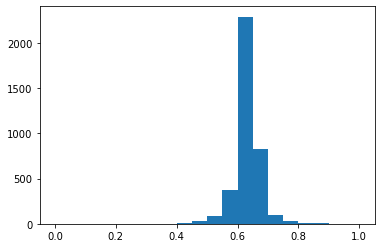

In [6]:
plt.hist(norm_data["Open%PriorClose"], bins=20)

(array([1363.,    0.,    0.,    0.,    0., 1138.,    0.,    0.,    0.,
        1270.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

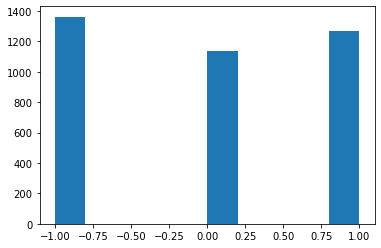

In [7]:
plt.hist(labels)

(array([  1.,   0.,   1.,   0.,   4.,   0.,   1.,   1.,   1.,   2.,   4.,
          6.,   8.,  12.,  18.,  23.,  59.,  70., 151., 223., 383., 694.,
        865., 649., 294., 139.,  77.,  30.,  18.,  18.,   3.,   3.,   1.,
          2.,   6.,   2.,   0.,   0.,   1.,   1.]),
 array([-8.21077528, -7.83852626, -7.46627724, -7.09402823, -6.72177921,
        -6.34953019, -5.97728118, -5.60503216, -5.23278314, -4.86053413,
        -4.48828511, -4.11603609, -3.74378707, -3.37153806, -2.99928904,
        -2.62704002, -2.25479101, -1.88254199, -1.51029297, -1.13804396,
        -0.76579494, -0.39354592, -0.0212969 ,  0.35095211,  0.72320113,
         1.09545015,  1.46769916,  1.83994818,  2.2121972 ,  2.58444621,
         2.95669523,  3.32894425,  3.70119327,  4.07344228,  4.4456913 ,
         4.81794032,  5.19018933,  5.56243835,  5.93468737,  6.30693638,
         6.6791854 ]),
 <BarContainer object of 40 artists>)

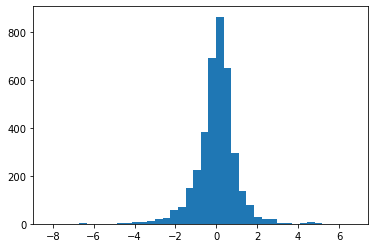

In [8]:
norm_N5D=(N5D-N5D.mean())/N5D.std()
plt.hist(norm_N5D, bins=40)

In [9]:
# Splitting training data to train and test data
train_data, test_data, train_labels, test_labels = train_test_split(
    norm_data, labels, test_size=0.2, shuffle=False)

## Take a look at the data sets
print("train_data:", train_data.shape)
print("train_labels:", train_labels.shape)
print("test_data:", test_data.shape)
print("test_labels:", test_labels.shape)

train_data: (3016, 47)
train_labels: (3016,)
test_data: (755, 47)
test_labels: (755,)


(array([258.,   0.,   0.,   0.,   0., 215.,   0.,   0.,   0., 282.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

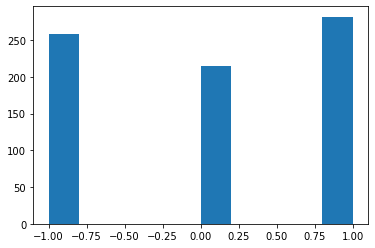

In [10]:
plt.hist(test_labels)

## Logistic Regression Model

In [24]:
## Logistic Regression model, feature select using L2 regularization
print("Logistic Regression Model:\n")
print("{:>8}  {:>10}{:>10}".format("L2 c", "accuracy", "f1"))
print("-" * 30)

# Produce Logistic Regression models with various C values
c_values = [0.01, 0.1, 1, 10, 100, 500, 1000, 2500, 5000, 7000, 8000, 9000, 10000, 20000]
best_c, best_f1 = 0, 0

for c in c_values:
    lr_model = LogisticRegression(C=c, solver="liblinear")
    lr_model.fit(train_data, train_labels)
    accuracy = lr_model.score(test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lr_model.predict(test_data), average='weighted')
    print("{:>8}  {:10.4f}{:10.4f}".format(c, accuracy, f1))
    if f1 > best_f1:
        best_c = c
        best_f1 = f1 

print("\nBest f1 score of {:.4f} at C={}".format(best_f1, best_c))
c_l2 = best_c

Logistic Regression Model:

    L2 c    accuracy        f1
------------------------------
    0.01      0.3748    0.3551
     0.1      0.3921    0.3888
       1      0.4185    0.4164
      10      0.4199    0.4183
     100      0.4185    0.4167
     500      0.4185    0.4163
    1000      0.4225    0.4206
    2500      0.4225    0.4214
    5000      0.4225    0.4222
    7000      0.4199    0.4196
    8000      0.4172    0.4169
    9000      0.4212    0.4209
   10000      0.4185    0.4183
   20000      0.4159    0.4156

Best f1 score of 0.4222 at C=5000


In [34]:
# Get the best model results
lr_model = LogisticRegression(C=c_l2, solver="liblinear")
lr_model.fit(train_data, train_labels)

LogisticRegression(C=5000, solver='liblinear')

### Take a look at the classification report

In [35]:
# First look at classification report
pred_labels = lr_model.predict(test_data)
score=lr_model.score(test_data, test_labels)
target_names = ['Sell', 'Hold', 'Buy']

print(classification_report(test_labels, pred_labels, target_names = target_names) )

              precision    recall  f1-score   support

        Sell       0.37      0.38      0.38       258
        Hold       0.42      0.50      0.46       215
         Buy       0.48      0.40      0.44       282

    accuracy                           0.42       755
   macro avg       0.42      0.43      0.42       755
weighted avg       0.43      0.42      0.42       755



(array([262.,   0.,   0.,   0.,   0., 259.,   0.,   0.,   0., 234.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

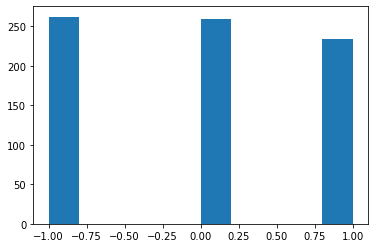

In [36]:
plt.hist(pred_labels)

In [38]:
print(confusion_matrix(test_labels, pred_labels))

[[ 98  84  76]
 [ 62 108  45]
 [102  67 113]]


### Examine feature coefficients of best model with L2 regularization

In [16]:
## Get the top features from the model
indices, features, sell_weights, hold_weights, buy_weights = [], [], [], [], []
indices.extend(np.argsort(-lr_model.coef_[2]))

for i in indices:
    features.append(train_data.columns[i])
    sell_weights.append(lr_model.coef_[0][i])
    hold_weights.append(lr_model.coef_[1][i])
    buy_weights.append(lr_model.coef_[2][i])
    
## Set up table to print results
print("Features from the Logistic Regression Model with Weights:\n")
print("{:>20}{:>20}{:>20}{:>20}".format("Features", "Sell Weight", "Hold Weight", "Buy Weight"))
print("-" * 80)

## Print the features along with weights
for i in range(int(len(features))):
        print("{:>20}{:20.4f}{:20.4f}{:20.4f}"
              .format(features[i], sell_weights[i], hold_weights[i], buy_weights[i]))

Features from the Logistic Regression Model with Weights:

            Features         Sell Weight         Hold Weight          Buy Weight
--------------------------------------------------------------------------------
              SMA30%            -14.3603             -2.6560             22.6297
          Close%High             -9.6313            -16.3704             17.3436
                S3C%             -7.0995            -13.3267             15.0458
              EMA50%            -15.3680              9.8892             12.9059
              SMA15%            -11.4134              5.6637             11.3289
              SMA50%             -8.0743              5.0334              8.1904
              SMA10%             -9.9227              7.7241              7.7228
               EMA5%             21.8623            -45.9426              7.5537
     Open%PriorClose             -9.6425              7.7672              5.5600
          Close%Open            -10.8929          

### Additional feature selection using both L1 and L2 regularization

In [31]:
## Improved Logistic Regression Model: using preprocessed training and dev data
np.random.seed(0) ## keep for comparison purposes

## Print result table headers
print("Logistic Regression Model with L1 and L2 Regularization:\n")
print("{:>15}{:>15}{:>15}{:>15}".format("L1 C value", "feature size", "accuracy", "f1"))
print("-" * 60)

## Produce Logistic Regression models with various C values for L1 regularization
c_values = c_values = [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
best_c, best_f1 = 0, 0

for c in c_values:
    ## Feature selection model with L1 regularization, test different C strengths
    lrm = LogisticRegression(C=c, solver="liblinear", penalty="l1", tol=0.015)
    lrm.fit(train_data, train_labels)

    ## Get non-zero features
    nz_features = []
    for i in range(len(features)):
        if abs(lrm.coef_[0][i]) > 0 or abs(lrm.coef_[2][i]) > 0:
            nz_features.append(features[i])
    
    ## New model with L2 regularization
    new_train_data = train_data[nz_features]
    new_test_data = test_data[nz_features]

    lrm = LogisticRegression(C=10, solver="liblinear", penalty="l2")
    lrm.fit(new_train_data, train_labels)
    accuracy = lrm.score(new_test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lrm.predict(new_test_data), average='weighted')
    print("{:>15}{:>15}{:>15.4f}{:>15.4f}".format(c, len(nz_features), accuracy, f1))
    if f1 > best_f1:
        best_c = c
        best_f1 = f1

print("\nBest f1 score of {:.4f} at L1 C={}".format(best_f1, best_c))
c_l1 = best_c

Logistic Regression Model with L1 and L2 Regularization:

     L1 C value   feature size       accuracy             f1
------------------------------------------------------------
           0.01              2         0.3815         0.3606
            0.1              5         0.3947         0.3814
            0.2             10         0.3934         0.3800
            0.5             22         0.4265         0.4172
              1             26         0.4238         0.4165
              2             29         0.4159         0.4085
              5             28         0.4238         0.4168
             10             29         0.4159         0.4085
             20             29         0.4159         0.4085
             50             29         0.4159         0.4085
            100             29         0.4159         0.4085
            200             29         0.4159         0.4085
            500             29         0.4159         0.4085

Best f1 score of 0.4172 at

Seeing not a ton of improvement, using simpler L1 regularization.

In [41]:
# Get the best model results
lr_model = LogisticRegression(C=c_l2, solver="liblinear")
lr_model.fit(train_data, train_labels)
pred_labels = lr_model.predict(test_data)